In [1]:
import h5py
import numpy as np

# Path to your HDF5 file
file_path = '5G_dataset/5G_training_data.hdf5'

# Create an empty dictionary to store NumPy arrays
data_dict = {}

# Open the HDF5 file
with h5py.File(file_path, 'r') as hdf:
    # Iterate over all datasets in the file
    for key in hdf.keys():
        dataset = hdf[key][:]
        data_dict[key] = dataset  # Store each dataset into the dictionary

# Now, you can access individual datasets as NumPy arrays
A_ID = data_dict['A_ID']
B_ID = data_dict['B_ID']
CIR_I = data_dict['CIR_I']
CIR_R = data_dict['CIR_R']
POS_X = data_dict['POS_X']
POS_Y = data_dict['POS_Y']
TD = data_dict['TD']
TD_OFFSET = data_dict['TD_OFFSET']
TIME_STAMP = data_dict['TIME_STAMP']

# For verification, print shapes of arrays
for key, value in data_dict.items():
    print(f"{key} shape: {value.shape}")

A_ID shape: (113203,)
B_ID shape: (113203,)
CIR_I shape: (113203, 128)
CIR_R shape: (113203, 128)
POS_X shape: (113203,)
POS_Y shape: (113203,)
TD shape: (113203,)
TD_OFFSET shape: (113203,)
TIME_STAMP shape: (113203,)


In [2]:
CIR=CIR_R+ 1j*CIR_I

In [3]:
grt_pos=np.stack((POS_X, POS_Y), axis=1)

In [4]:
def feature_extraction_F1(cir_matrix):
    R = cir_matrix * np.conj(cir_matrix)
    r = R.flatten()
    r_real = np.real(r)
    r_imag = np.imag(r)
    r_R = np.concatenate((r_real, r_imag))
    feature_vector = r_R / np.linalg.norm(r_R)
    return feature_vector

features_F1_cir = np.array([feature_extraction_F1(cir) for cir in CIR])
print("Shape of Features (F1_cir):", features_F1_cir.shape)

Shape of Features (F1_cir): (113203, 256)


In [5]:
from sklearn.model_selection import train_test_split
X_train, x1, y_train, y1 = train_test_split(features_F1_cir, grt_pos, test_size=0.4, random_state=42)
X_test, X_pred, y_test, y_pred = train_test_split(x1, y1, test_size=0.5, random_state=42)

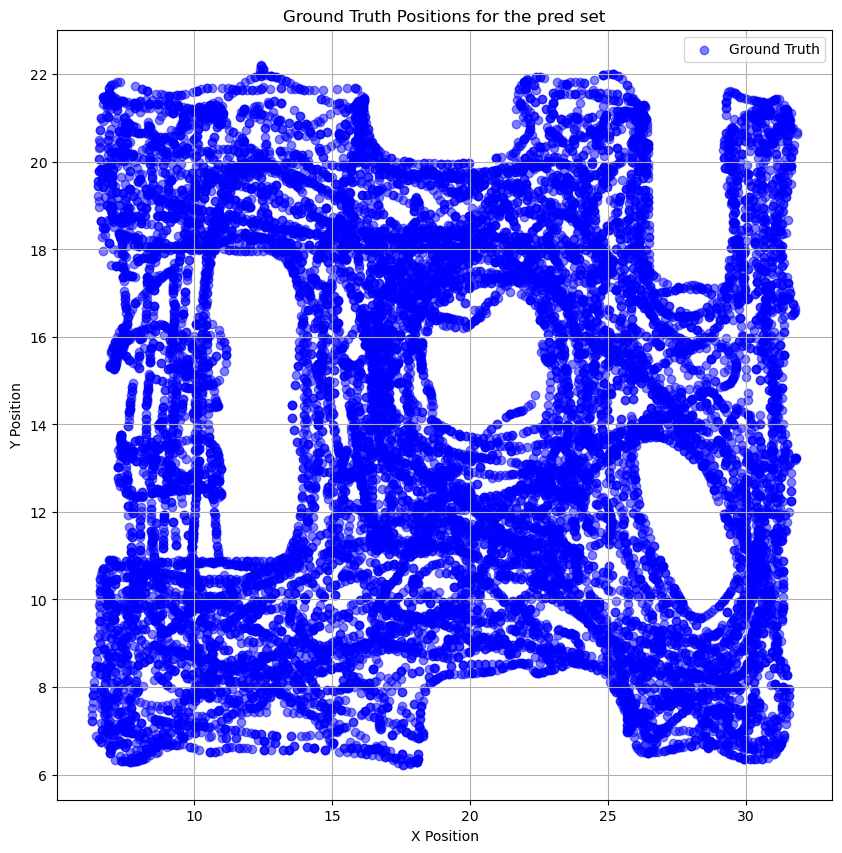

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(y_pred[:, 0], y_pred[:, 1], c='blue', label='Ground Truth', alpha=0.5)
plt.title('Ground Truth Positions for the pred set')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

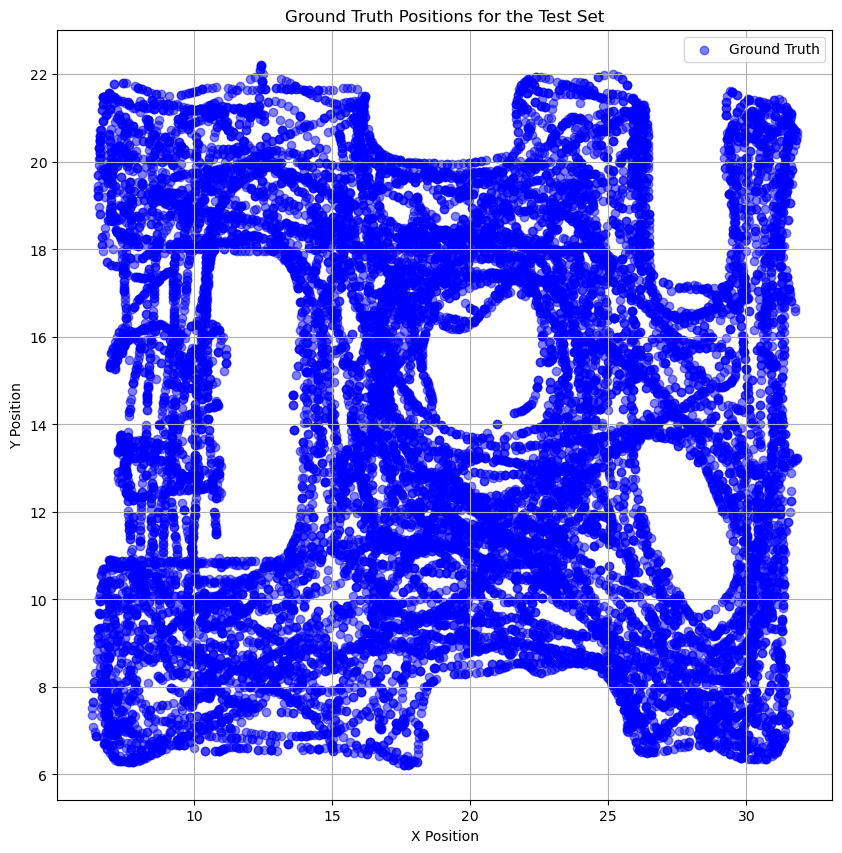

In [7]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test[:, 0], y_test[:, 1], c='blue', label='Ground Truth', alpha=0.5)
plt.title('Ground Truth Positions for the Test Set')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

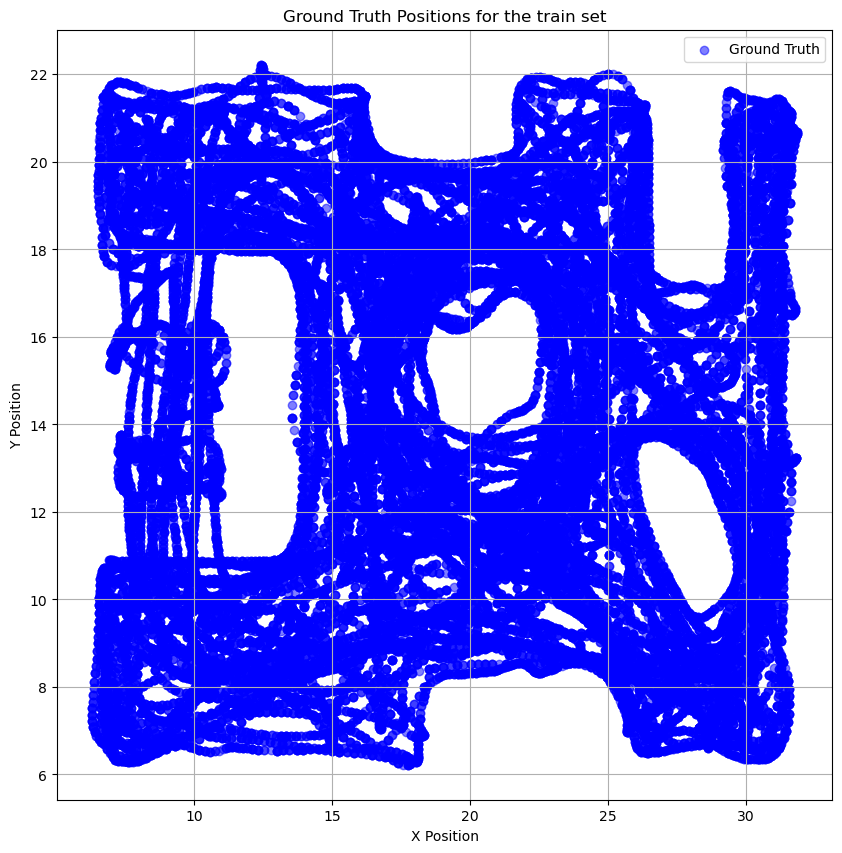

In [8]:
plt.figure(figsize=(10, 10))
plt.scatter(y_train[:, 0], y_train[:, 1], c='blue', label='Ground Truth', alpha=0.5)
plt.title('Ground Truth Positions for the train set')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import numpy as np
from scipy.special import softmax

def build_grid(grid_size=30, space_bounds=None):
    (xmin, xmax), (ymin, ymax) = space_bounds
    x_lin = np.linspace(xmin, xmax, grid_size)
    y_lin = np.linspace(ymin, ymax, grid_size)
        
    xv, yv = np.meshgrid(x_lin, y_lin)
    grid_points = np.stack([xv.ravel(), yv.ravel()], axis=1)
    return grid_points

def compute_soft_probability_maps(positions, grid_points, temperature=.1):
    N = positions.shape[0]
    K = grid_points.shape[0]
    dists = np.linalg.norm(positions[:, np.newaxis, :] - grid_points[np.newaxis, :, :], axis=2)
    sim_scores = -dists / temperature
    prob_maps = softmax(sim_scores, axis=1)
    return prob_maps

def estimate_positions_from_maps(prob_maps, grid_points):
    return np.matmul(prob_maps, grid_points)

def generate_all_probability_maps(positions, grid_size=30, temperature=.1):
    x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
    y_min, y_max = positions[:, 1].min(), positions[:, 1].max()
    print("Position bounds:", (x_min, x_max), (y_min, y_max))
    grid_points = build_grid(grid_size, space_bounds=((x_min, x_max), (y_min, y_max)))
    print("Grid points shape:", grid_points.shape)
    prob_maps = compute_soft_probability_maps(positions, grid_points, temperature=temperature)

    est_locations = estimate_positions_from_maps(prob_maps, grid_points)

    return prob_maps, est_locations, grid_points

In [10]:
def plot_heatmap(prob_map, grid_points, title="Heatmap"):
    plt.figure(figsize=(8, 6))
    plt.imshow(prob_map.reshape(30, 30), extent=(grid_points[:, 0].min(), grid_points[:, 0].max(),
                                                  grid_points[:, 1].min(), grid_points[:, 1].max()),
               origin='lower', cmap='hot', alpha=0.7)
    plt.colorbar(label='Probability')
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()

In [11]:
prob_map_test, est_locations_test, grid_points_test = generate_all_probability_maps(y_test, grid_size=30, temperature=0.1)
prob_map_train, est_locations_train, grid_points_train = generate_all_probability_maps(y_train, grid_size=30, temperature=0.1)
prob_map_pred, est_locations_pred, grid_points_pred = generate_all_probability_maps(y_pred, grid_size=30, temperature=0.1)

Position bounds: (6.307980483878724, 31.82647141325833) (6.223295579572582, 22.220579267617712)
Grid points shape: (900, 2)
Position bounds: (6.307980483846373, 31.837173051937405) (6.22329557621037, 22.22057926919299)
Grid points shape: (900, 2)
Position bounds: (6.307980484593721, 31.837173049773977) (6.223707326117879, 22.220579267647388)
Grid points shape: (900, 2)


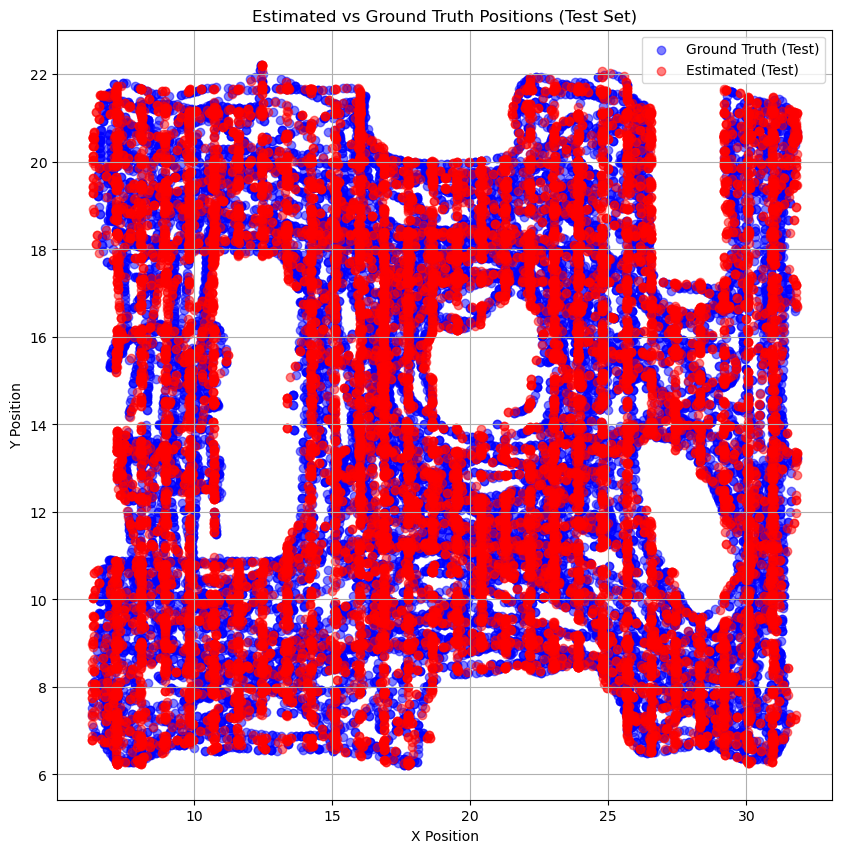

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test[:, 0], y_test[:, 1], c='blue', label='Ground Truth (Test)', alpha=0.5)
plt.scatter(est_locations_test[:, 0], est_locations_test[:, 1], c='red', label='Estimated (Test)', alpha=0.5)
plt.title('Estimated vs Ground Truth Positions (Test Set)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
from keras import layers
import tensorflow as tf

class NeuralNetwork(tf.keras.Model):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = layers.Dense(2048, input_dim=input_size,activation="gelu")
        self.bn1 = layers.BatchNormalization()
        self.fc2 = layers.Dense(2048,activation="gelu")
        self.bn2 = layers.BatchNormalization()
        self.fc3 = layers.Dense(2048,activation="gelu")
        self.fc4 = layers.Dense(2048,activation="gelu")
        self.fc5 = layers.Dense(2048,activation="gelu")
        self.bn5 = layers.BatchNormalization()
        self.fc6=layers.Dense(output_size,activation="softmax")


    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.bn1(x)

        x = self.fc2(x)
        x = self.bn2(x)

        x = self.fc3(x)

        x = self.fc4(x)

        x = self.fc5(x)
        x = self.bn5(x)

        x = self.fc6(x)
        return x

# Set output_size to the number of grid points (e.g., 900 for 30x30 grid)
output_size = grid_points_train.shape[0]  # grid_points from your earlier code
print(output_size)

900


In [14]:
y_train.shape,X_train.shape

((67921, 2), (67921, 256))

In [15]:
features_F1_cir.shape[1]

256

In [16]:
# model=NeuralNetwork(input_size=features_F1_cir.shape[1], output_size=output_size)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# model.fit(X_pred, prob_map_pred, epochs=300, batch_size=32, validation_split=0.2)

In [18]:
predicted_maps = model.predict(X_test)
plot_heatmap(predicted_maps[2], grid_points_test, title="Predicted Heatmap for First Test Position")
print(f"Estimated :- {estimate_positions_from_maps(predicted_maps, grid_points_test)[2]}")
print(f"Ground Truth :- {y_test[2]}")
plot_heatmap(prob_map_test[2], grid_points_test, title="Heatmap for First Test Position")
predicted_positions = np.matmul(predicted_maps, grid_points_test)
mae = np.mean(np.abs(y_test - predicted_positions), axis=0)
print("Mean Absolute Error (Position Predictions):", mae)

NameError: name 'model' is not defined

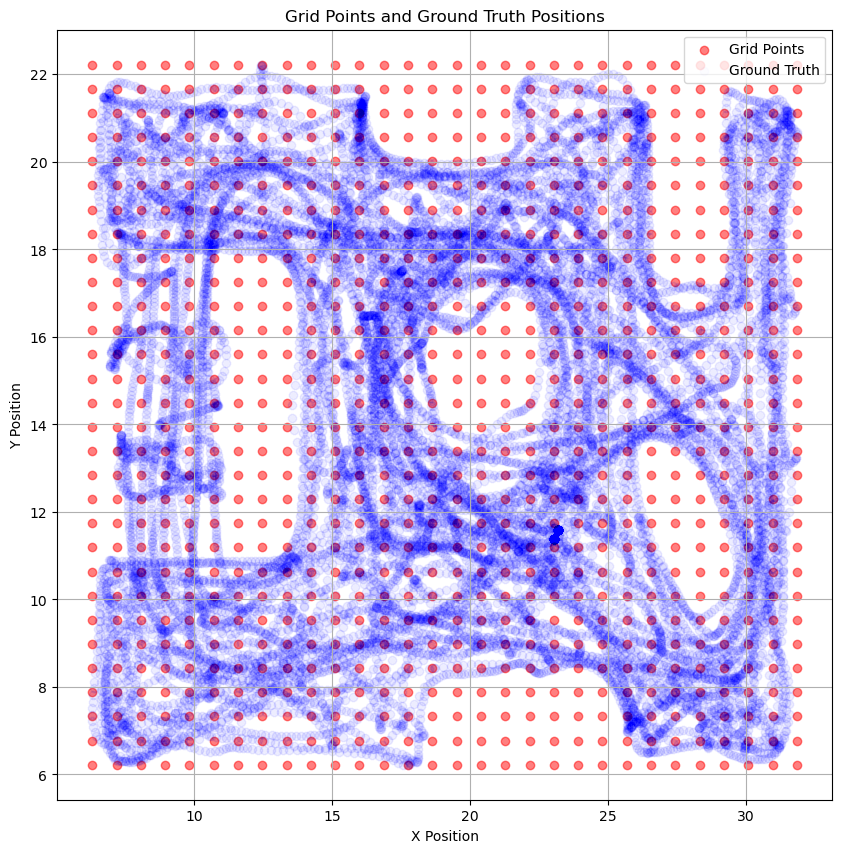

In [19]:
grid_points = build_grid(grid_size=30, space_bounds=((grt_pos[:, 0].min(), grt_pos[:, 0].max()),
                                                    (grt_pos[:, 1].min(), grt_pos[:, 1].max())))
# Plot the grid points
plt.figure(figsize=(10, 10))
plt.scatter(grid_points[:, 0], grid_points[:, 1], c='red', label='Grid Points', alpha=0.5)
plt.scatter(grt_pos[:, 0], grt_pos[:, 1], c='blue', label='Ground Truth', alpha=0.01)
plt.title('Grid Points and Ground Truth Positions')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
predicted_maps.shape, grid_points_test.shape

In [ ]:
jk=estimate_positions_from_maps(predicted_maps, grid_points_test)

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test[:, 0], y_test[:, 1], c='blue', label='Ground Truth (Test)', alpha=0.5)
plt.scatter(jk[:, 0], jk[:, 1], c='red', label='Estimated (Test)', alpha=0.5)
plt.title('Estimated vs Ground Truth Positions (Test Set)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
import tensorflow as tf
from keras import layers, models, regularizers

def build_csi_probmap_mlp(input_dim: int = 256,hidden_units: tuple = (1024, 512, 512,512),dropout_rate: float = 0.2,l2_coeff: float = 1e-4) -> tf.keras.Model:
    inputs = layers.Input(shape=(input_dim,))
    x = inputs
    for i, width in enumerate(hidden_units, start=1):
        x = layers.Dense(width, activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_coeff))(x)
        x = layers.Dropout(dropout_rate)(x)
    logits = layers.Dense(900, activation=None)(x)
    outputs = layers.Activation("softmax")(logits)
    return models.Model(inputs, outputs)

In [21]:
pred_ds = tf.data.Dataset.from_tensor_slices((X_pred, prob_map_pred))
pred_ds = pred_ds.shuffle(buffer_size=1024).batch(32)

2025-07-09 09:54:23.309759: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-07-09 09:54:23.309788: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-07-09 09:54:23.309793: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-07-09 09:54:23.309853: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-09 09:54:23.309887: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
model2 = build_csi_probmap_mlp()

adamw = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4)

model2.compile(optimizer=adamw,
               loss='categorical_crossentropy',
               metrics=['accuracy'])


In [23]:
model2.optimizer=adamw

In [ ]:
model2.fit(pred_ds, epochs=100, validation_data=pred_ds)

Epoch 1/100


2025-07-09 09:54:28.701599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


708/708 [==============================] - ETA: 0s - loss: 6.4680 - accuracy: 0.0228

2025-07-09 09:54:44.353390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


708/708 [==============================] - 24s 33ms/step - loss: 6.4680 - accuracy: 0.0228 - val_loss: 6.2271 - val_accuracy: 0.0261
Epoch 2/100
708/708 [==============================] - 24s 34ms/step - loss: 6.2214 - accuracy: 0.0259 - val_loss: 6.1554 - val_accuracy: 0.0291
Epoch 3/100
708/708 [==============================] - 24s 34ms/step - loss: 6.1671 - accuracy: 0.0296 - val_loss: 6.1173 - val_accuracy: 0.0317
Epoch 4/100
707/708 [============================>.] - ETA: 0s - loss: 6.1095 - accuracy: 0.0305

In [ ]:
predicted_maps = model2.predict(X_pred)
plot_heatmap(predicted_maps[2], grid_points_pred, title="Predicted Heatmap for First Test Position")
print(f"Estimated :- {estimate_positions_from_maps(predicted_maps, grid_points_pred)[2]}")
print(f"Ground Truth :- {y_pred[2]}")
plot_heatmap(prob_map_pred[2], grid_points_pred, title="Heatmap for First Test Position")
predicted_positions = np.matmul(predicted_maps, grid_points_pred)
mae = np.mean(np.abs(y_pred - predicted_positions), axis=0)
print("Mean Absolute Error (Position Predictions):", mae)

In [ ]:
jk=estimate_positions_from_maps(predicted_maps, grid_points_pred)

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(y_pred[:, 0], y_pred[:, 1], c='blue', label='Ground Truth (Test)', alpha=0.7)
plt.scatter(jk[:, 0], jk[:, 1], c='red', label='Estimated (Test)', alpha=0.1)
plt.title('Estimated vs Ground Truth Positions (Test Set)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
import math

def random_attack(features, lp=None, epsilon=1.0, seed=None):
    """
    Executes the random (black‑box) attack on a batch of CSI features.

    Parameters
    ----------
    features : tf.Tensor
        Real‑valued tensor with shape (m, 832).
    lp : int, optional
        Perturbation length L_p (defaults to 832).
    epsilon : float, optional
        Scaling coefficient for the perturbation's magnitude.
    seed : int, optional
        If provided, enforces deterministic sampling.

    Returns
    -------
    tf.Tensor
        Perturbed feature tensor of identical shape to `features`.
    """
    lp = lp or features.shape[-1]

    # RNG initialisation
    gen = (tf.random.Generator.from_seed(seed)
           if seed is not None
           else tf.random.Generator.from_non_deterministic_state())

    batch = tf.shape(features)[0]

    # Amplitudes A_k ∼ U([0,1])
    A = gen.uniform(shape=(batch, lp), minval=0.0, maxval=1.0, dtype=tf.float32)

    # Phases φ_k ∼ U([0, 2π))
    phi = gen.uniform(shape=(batch, lp), minval=0.0, maxval=2.0 * math.pi, dtype=tf.float32)

    # Complex perturbation  p_k = A_k · e^{jφ_k}
    perturb_complex = tf.complex(A * tf.cos(phi), A * tf.sin(phi))

    # Normalise to unit ℓ₂ norm per sample
    norm = tf.linalg.norm(perturb_complex, axis=-1, keepdims=True)
    perturb_unit = perturb_complex / norm

    # Convert to real domain (drop imag.) and add to features
    perturb_real = tf.math.real(perturb_unit)
    return features + epsilon * perturb_real